In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import json
from tqdm import tqdm
import html
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Cell 2: Define the Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=512):
        self.texts = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Read JSONL file
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                cleaned_text = self.preprocess_text(data['text'])
                self.texts.append(cleaned_text)
                self.labels.append(1 if data['label'] == 1 else 0)  #1 = machine

    def preprocess_text(self, text):
        # Decode HTML entities
        text = html.unescape(text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Remove special characters and numbers (optional, be careful as it might remove important features)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Convert to lowercase (optional, RoBERTa is case-sensitive by default)
        text = text.lower()
        
        # Remove leading/trailing whitespace
        text = text.strip()
        
        return text
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [3]:
# Cell 3: Define training and evaluation functions
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

In [4]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += len(labels)
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

In [5]:
# Cell 4: Initialize tokenizer, model, and device
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [6]:
# Cell 5: Create datasets and dataloaders
train_dataset = TextClassificationDataset('train/train_short.jsonl', tokenizer)
val_dataset = TextClassificationDataset('val/val_short.jsonl', tokenizer)
test_dataset = TextClassificationDataset('test/test_short.jsonl', tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 8000
Validation samples: 1000
Test samples: 1000


In [7]:
# Cell 6: Initialize optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\dhyey\anaconda3\envs\cudatest\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*Torch was not compiled with flash attention.*")

In [9]:
# Cell 7: Training loop
num_epochs = 3
best_val_accuracy = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    
    # Validate
    with torch.no_grad():
        val_loss, val_acc = evaluate(model, val_loader, device)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'New best validation accuracy: {best_val_accuracy:.4f}')

    torch.cuda.empty_cache()
    
    print()

Epoch 1/3
----------


100%|██████████| 500/500 [1:22:38<00:00,  9.92s/it]


Training Loss: 0.0983, Training Accuracy: 0.9625
Validation Loss: 0.0573, Validation Accuracy: 0.9810
New best validation accuracy: 0.9810

Epoch 2/3
----------


100%|██████████| 500/500 [1:23:14<00:00,  9.99s/it]


Training Loss: 0.0448, Training Accuracy: 0.9846
Validation Loss: 0.0558, Validation Accuracy: 0.9850
New best validation accuracy: 0.9850

Epoch 3/3
----------


100%|██████████| 500/500 [1:12:36<00:00,  8.71s/it]


Training Loss: 0.0167, Training Accuracy: 0.9948
Validation Loss: 0.1677, Validation Accuracy: 0.9640



In [10]:
# Cell 10: Save model and tokenizer
# Create a directory to save the model and tokenizer
import os
save_directory = 'roberta_text_classifier'
os.makedirs(save_directory, exist_ok=True)

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to roberta_text_classifier


In [ ]:
# # Cell 8: Evaluate on test set using best model
# model.load_state_dict(torch.load('best_model.pt'))
# test_loss, test_acc = evaluate(model, test_loader, device)
# print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

In [14]:
# Add this new cell after the training functions
# Cell: Define comprehensive evaluation function
def evaluate_with_metrics(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability for positive class
    
    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, target_names=['Human', 'Machine'], output_dict=True)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    
    # Calculate additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'precision': tp / (tp + fp),
        'recall': tp / (tp + fn),
        'f1_score': class_report['weighted avg']['f1-score'],
        'specificity': specificity,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_curve': (fpr, tpr),
        'pr_curve': (precision, recall)
    }
    
    return metrics

def plot_metrics(metrics, title_prefix=""):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(metrics['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Human', 'Machine'],
                yticklabels=['Human', 'Machine'])
    plt.title(f'{title_prefix}Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 2. ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr = metrics['roc_curve']
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}ROC Curve')
    plt.legend(loc="lower right")
    
    # 3. Precision-Recall Curve
    plt.subplot(2, 2, 3)
    precision, recall = metrics['pr_curve']
    plt.plot(recall, precision, label=f'PR curve (AUC = {metrics["pr_auc"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix}Precision-Recall Curve')
    plt.legend(loc="lower left")

    roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    pr_data = pd.DataFrame({'Recall': recall, 'Precision': precision})
    
    roc_data.to_csv('roc_curve_newRoberta.csv', index=False)
    pr_data.to_csv('pr_curve_newRoberta.csv', index=False)
    
    # 4. Metrics Summary
    plt.subplot(2, 2, 4)
    metrics_to_plot = {
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'Specificity': metrics['specificity'],
        'ROC AUC': metrics['roc_auc']
    }
    
    plt.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    plt.title(f'{title_prefix}Metrics Summary')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(metrics):
    print("\nDetailed Performance Metrics:")
    print("-" * 50)
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"False Positive Rate: {metrics['false_positive_rate']:.4f}")
    print(f"False Negative Rate: {metrics['false_negative_rate']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"PR AUC: {metrics['pr_auc']:.4f}")
    
    print("\nClassification Report:")
    print(pd.DataFrame(metrics['classification_report']).transpose())

100%|██████████| 63/63 [00:33<00:00,  1.91it/s]


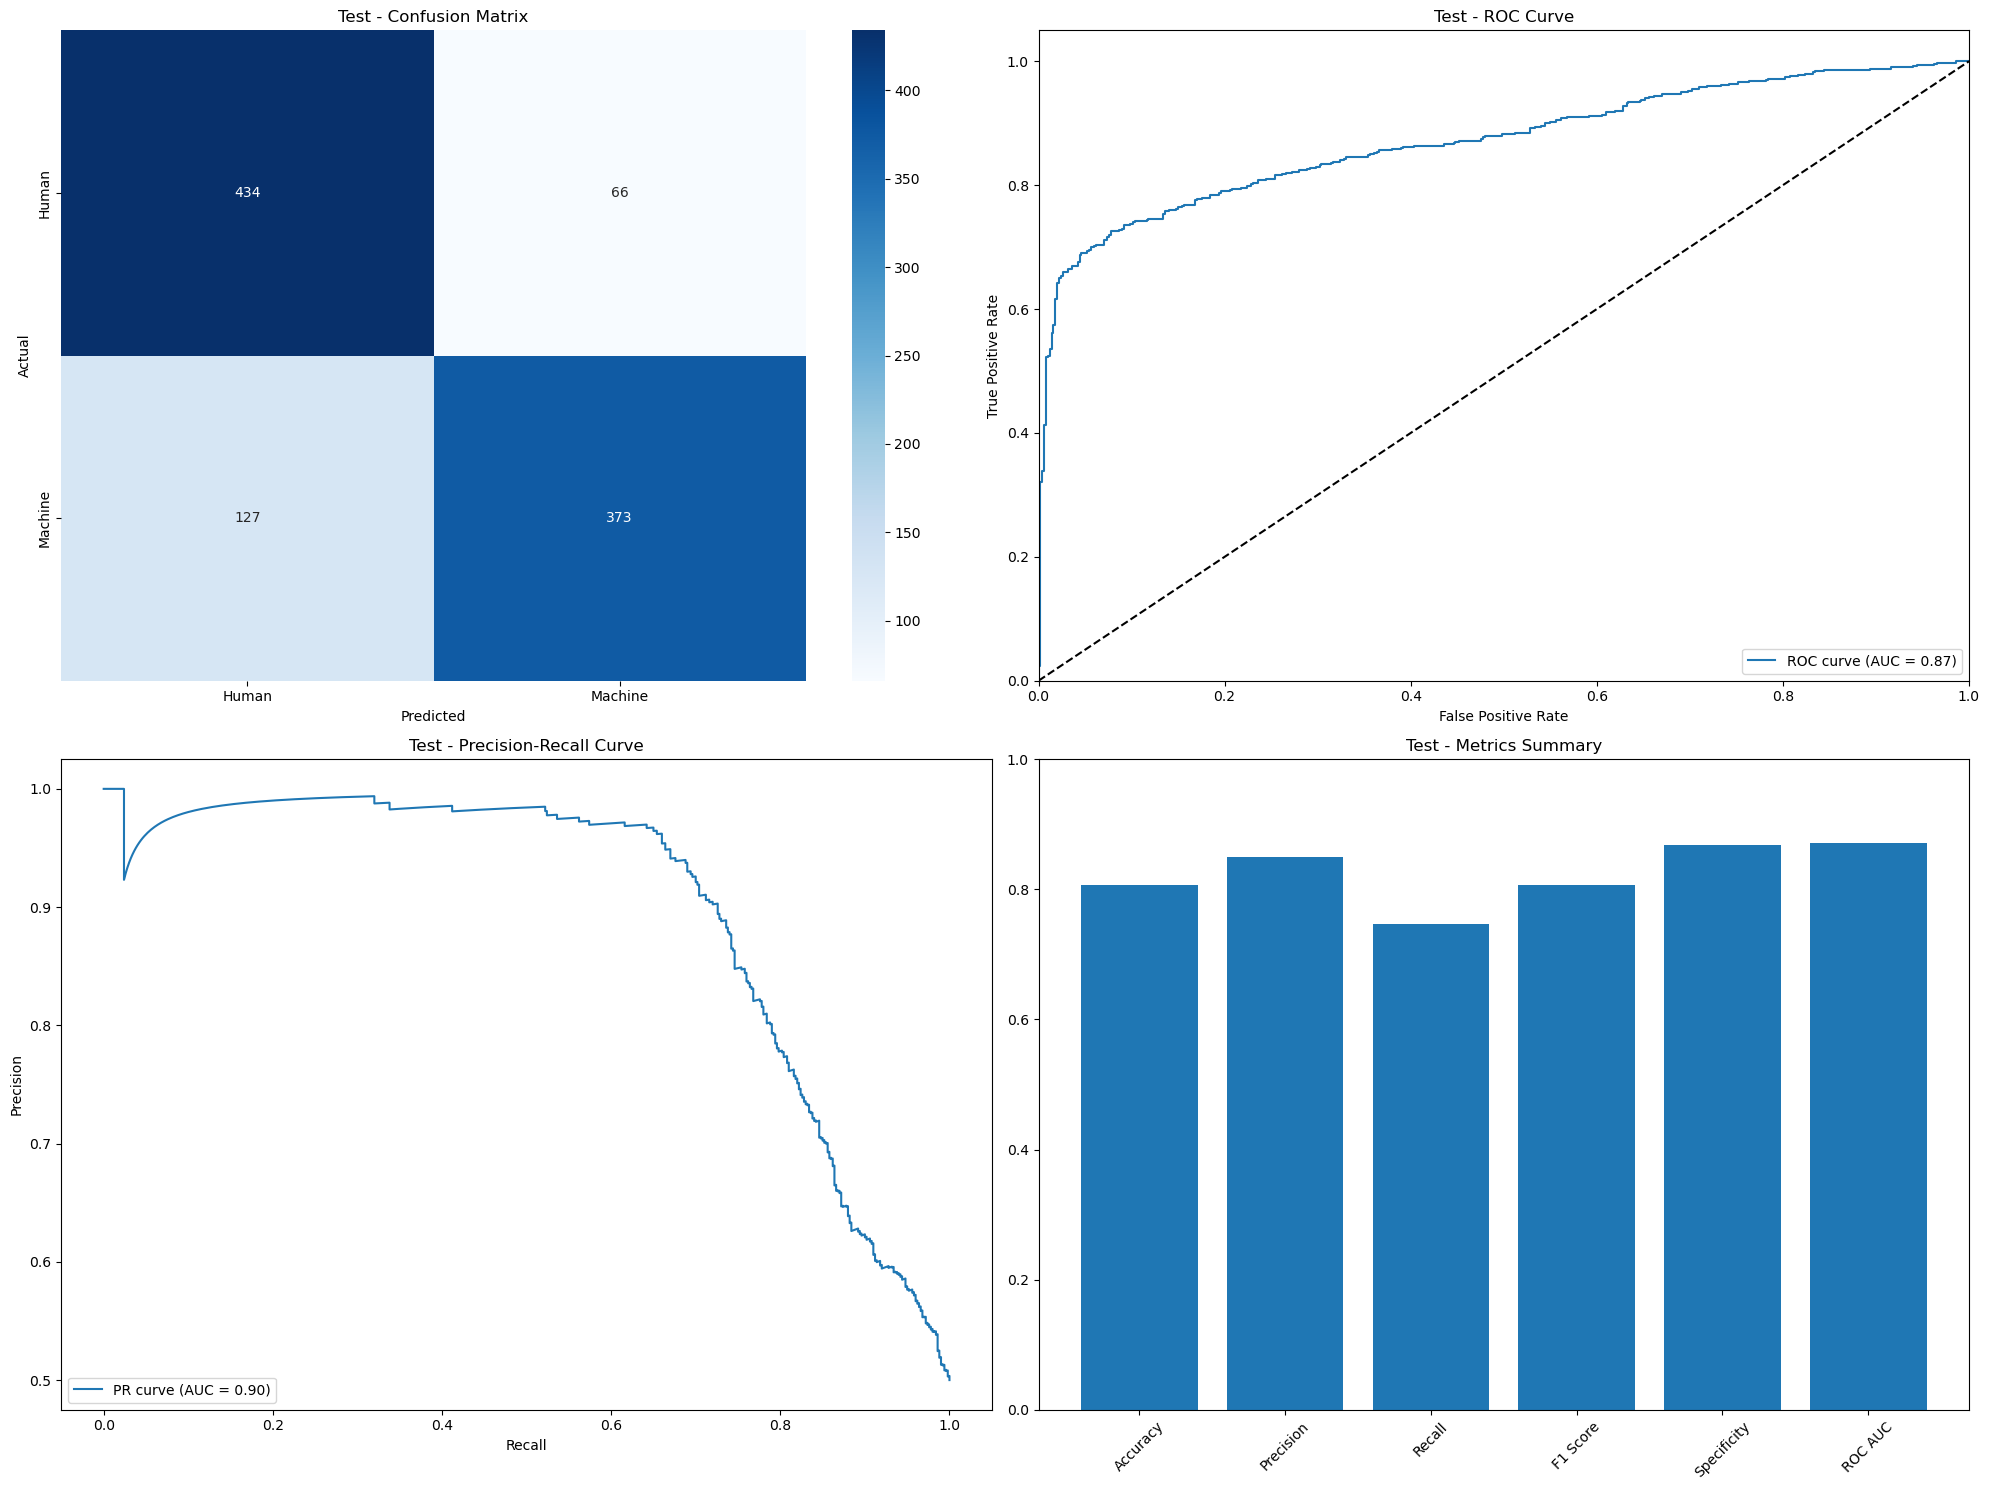


Detailed Performance Metrics:
--------------------------------------------------
Loss: 0.8063
Accuracy: 0.8070
Precision: 0.8497
Recall: 0.7460
F1 Score: 0.8063
Specificity: 0.8680
False Positive Rate: 0.1320
False Negative Rate: 0.2540
ROC AUC: 0.8712
PR AUC: 0.8980

Classification Report:
              precision  recall  f1-score   support
Human          0.773619   0.868  0.818096   500.000
Machine        0.849658   0.746  0.794462   500.000
accuracy       0.807000   0.807  0.807000     0.807
macro avg      0.811638   0.807  0.806279  1000.000
weighted avg   0.811638   0.807  0.806279  1000.000


In [15]:
# Replace Cell 8 (Evaluate on test set) with:
# Cell 8: Final evaluation on test set
model.load_state_dict(torch.load('best_model.pt'))
test_metrics = evaluate_with_metrics(model, test_loader, device)

# Plot test metrics
plot_metrics(test_metrics, title_prefix="Test - ")
print_detailed_metrics(test_metrics)

# Save metrics to file
with open('test_metrics.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    serializable_metrics = {k: v.tolist() if hasattr(v, 'tolist') else v 
                          for k, v in test_metrics.items() 
                          if k not in ['roc_curve', 'pr_curve']}
    json.dump(serializable_metrics, f, indent=4)

In [ ]:
import gc
gc.collect()